# Example of ORA and GSEA

We first run the same steps as in the previous notebook on multiple testing.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ![ ! -f "dsbook/README.md" ] && git clone https://github.com/statisticalbiotechnology/dsbook.git
    my_path = "dsbook/dsbook/common/"
else:
    my_path = "../common/"
sys.path.append(my_path) # Read local modules for tcga access and qvalue calculations
import load_tcga as tcga
import qvalue 

brca = tcga.get_expression_data(my_path + "../data/brca_tcga_pub2015.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/brca_tcga_pub2015.tar.gz',"data_mrna_seq_v2_rsem.txt")
brca_clin = tcga.get_clinical_data(my_path + "../data/brca_tcga_pub2015.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)
brca_clin.loc["3N"]= (brca_clin.loc["PR_STATUS_BY_IHC"]=="Negative") & (brca_clin.loc["ER_STATUS_BY_IHC"]=="Negative") & (brca_clin.loc["IHC_HER2"]=="Negative")
tripple_negative_bool = (brca_clin.loc["3N"] == True)

def get_significance_two_groups(row):
    log_fold_change = row[tripple_negative_bool].mean() - row[~tripple_negative_bool].mean()
    p = ttest_ind(row[tripple_negative_bool],row[~tripple_negative_bool],equal_var=False)[1]
    return [p,-np.log10(p),log_fold_change]

pvalues = brca.apply(get_significance_two_groups,axis=1,result_type="expand")
pvalues.rename(columns = {list(pvalues)[0]: 'p', list(pvalues)[1]: '-log_p', list(pvalues)[2]: 'log_FC'}, inplace = True)
qvalues = qvalue.qvalues(pvalues)

File extracted to ../data/brca_tcga_pub2015
File extracted to ../data/brca_tcga_pub2015


If we investigate a Volcano plot of the tripple negative cancers vs. the other cancers, we see an large number of both up and down regulated genes. We will in this note book ecamine if there are common patterns in the up and down regulation. 

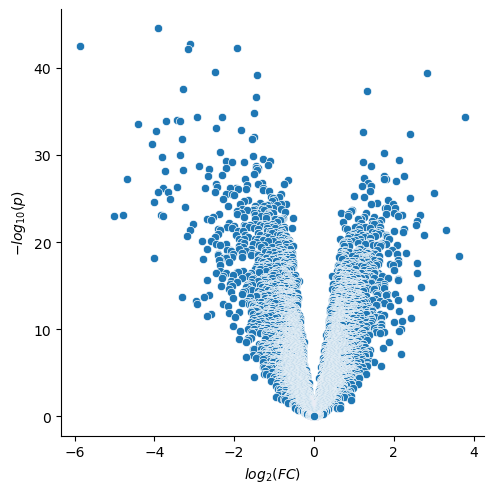

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(data=qvalues,x="log_FC",y="-log_p")
plt.xlabel("$log_2(FC)$")
plt.ylabel("$-log_{10}(p)$")
plt.show()

### Over-representation analysis

We use the [gseapy](https://gseapy.readthedocs.io/) module to run an overrepresentation analysis. The module is unfortunately not implementing pathway analysis itself. It instead call a remote webserver[Enrichr](http://amp.pharm.mssm.edu/Enrichr/).  

In the analysis here we use the [KEGG](https://www.genome.jp/kegg/) database's definition of metabolomic pathways. This choice can easily be changed to other databases such as GO.

Here we select to use the $q$ values below $10^{-12}$ as an input for the analysis. First we select this as our gene_list, and then we calculate the overlap of the gene list to all the pathwauys in KEGG. 

In [3]:
import gseapy as gp

pathway_db=['KEGG_2019_Human']
background=set(qvalues.index)
gene_list = list(qvalues.loc[qvalues["q"]<1e-12,"q"].index)

output_enrichr=pd.DataFrame()
enr=gp.enrichr(
                gene_list=gene_list,
                gene_sets=pathway_db,
                background=background,
                outdir = None
            )


In [4]:
len(gene_list)

1403

We clean up the results a bit by only keeping some of the resulting metics. We also multiple hypothesis correct our results, and list the terms with a FDR less than 5%.

In [5]:
kegg_enr = enr.results[["P-value","Term"]].rename(columns={"P-value": "p"})
kegg_enr = qvalue.qvalues(kegg_enr)
kegg_enr.loc[kegg_enr["q"]<0.20]

,p,Term,q
0,0.000002,Cell cycle,0.000701
1,0.000265,Hedgehog signaling pathway,0.037638
2,0.001870,Prostate cancer,0.176826


The analysis seem to find overrepresentation of relatively few pathways, particularly given the significance of the differences between case and controll on transcript level. 

## Geneset Enrichment analysis

Subsequently we us pygsea to perform a geneset enricment analysis (GSEA). This time we compare to pathways in GSEAs oncogenic signature database, [MSigDB](https://www.gsea-msigdb.org/gsea/msigdb/index.jsp).


In [6]:
classes = ["TrippleNeg" if tripple_negative_bool[sample_name] else "Respond" for sample_name in brca.columns]
gs = gp.GSEA(data=brca, 
                 gene_sets='MSigDB_Oncogenic_Signatures', 
#                 gene_sets='KEGG_2019_Human', 
                 classes=classes, # cls=class_vector
                 permutation_type='phenotype', # null from permutations of class labels
                 permutation_num=2000, # reduce number to speed up test
                 min_size=15, # minimal size of pathway 
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 method='signal_to_noise',
                 threads=4, # Number of allowed parallel processes
                 seed=42,
                 format='png',)
                 # ascending=True)
gs.run()
gs_res = gs.res2d


2024-11-19 16:31:57,187 [WARNING] Found duplicated gene names, values averaged by gene names!


We first list the pathways with a FDR < 0.5.

In [7]:
significant = gs_res[gs_res["FDR q-val"]<0.5]
significant

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,RPS14 DN.V1 DN,-0.506616,-1.809224,0.018145,0.424336,0.1695,69/152,20.65%,PSAT1;CLCN4;SUV39H2;CDC20;MCM5;KIF2C;CDCA3;ASN...
1,gsea,CSR LATE UP.V1 UP,-0.572861,-1.771695,0.014911,0.308419,0.2205,81/138,21.54%,LYAR;FANCA;CDCA8;MRAS;SNRPA1;FOXM1;CHEK2;RPF2;...
3,gsea,E2F1 UP.V1 UP,-0.448257,-1.711008,0.01608,0.354616,0.318,82/167,30.03%,NDUFAF4;E2F3;AURKB;PIM1;KIFC1;CHEK1;UCK2;NASP;...
5,gsea,RB P107 DN.V1 UP,-0.518007,-1.639151,0.052427,0.47894,0.4595,56/122,21.09%,CCNE1;STMN1;FANCA;MCM7;MCM5;ORC6;GTSE1;CDC25B;...


The package we are using for accessing GSEA, gseapy, has some built in plotting routine for illustrating the enrichment for any given pathway.  

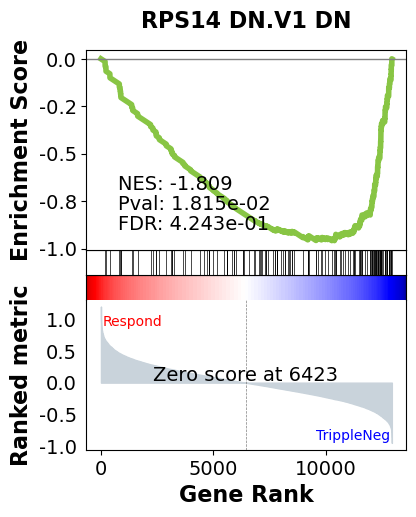

In [8]:
axs = gs.plot(terms=significant.Term[0])

We can also compare the enrichment between multiple pathways 

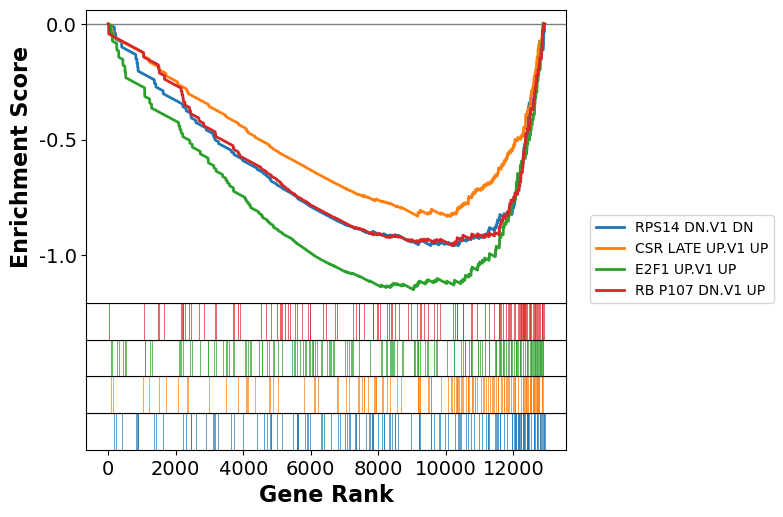

In [9]:
axs = gs.plot(significant.Term, show_ranking=False, legend_kws={'loc': (1.05, 0)}, )


as well as the heatmap (Normalized gene expression as a function of Gene and patient) for the genes in a given pathway.

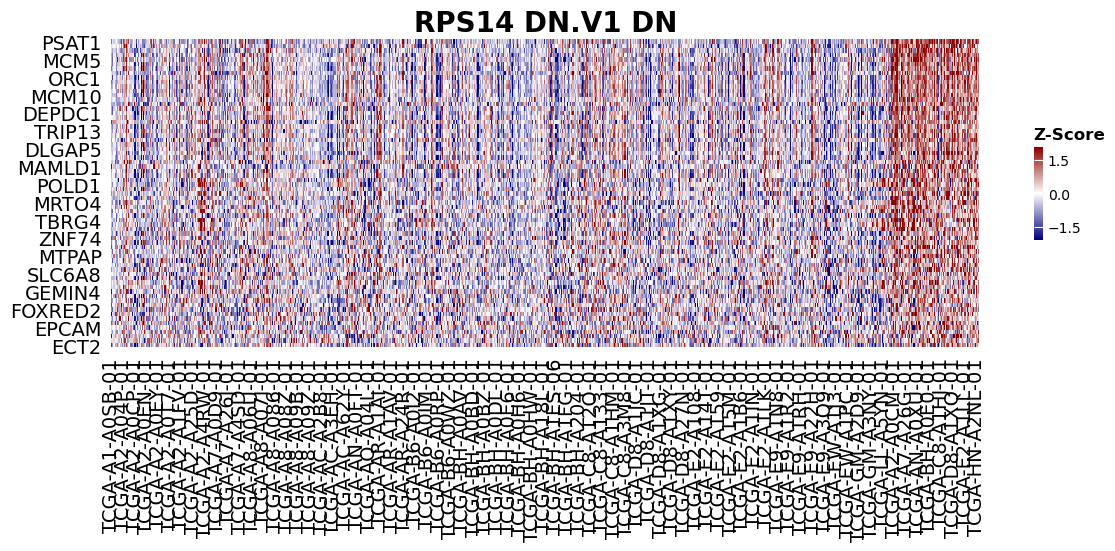

In [10]:
from gseapy import heatmap
# plotting heatmap
i = 0
genes = gs.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
ax = heatmap(df = gs.heatmat.loc[genes], z_score=0, title=gs_res.Term[i], figsize=(14,4))
